In [1]:
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
import scipy.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class NSGPRegression():
    def __init__(self, X, y, num_inducing_points, seed=0):
        self.num_inducing_points = num_inducing_points
        self.X = X
        self.y = y
        torch.manual_seed(seed)
        np.random.seed(seed)

        assert len(X.shape) == 2
        assert len(y.shape) == 2
        self.input_dim = X.shape[1]
        
        # Defining X_bar (Locations where latent lengthscales are to be learnt)
        # XY_choice = tf.concat([self.X, self.y], dim=1)
        self.X_bar = torch.tensor(KMeans(n_clusters=num_inducing_points, random_state=seed).fit(self.X).cluster_centers_)
        
#         self.X_bar = X[np.random.choice(X.shape[0], self.num_inducing_points, replace=False)]
        
        # initialize params
        self.init(seed)
        
    def init(self, seed):
        torch.manual_seed(seed)
        self.params = {}
        f = lambda size: (1+torch.rand(size)).requires_grad_()
        self.params['local_gp_std'] = f((self.input_dim,))
        self.params['local_gp_ls'] = f((self.input_dim,))
        self.params['local_gp_noise'] = f((self.input_dim,))
        self.params['latent_ls'] = f((self.num_inducing_points, self.input_dim))
        self.params['global_gp_std'] = f((1,))
        self.params['global_gp_noise'] = f((1,))
        
#         self.dparams = self.params.copy() # Saving gradients
        
    def LocalKernel(self,x1,x2,dim): # return local kernel without variance
        x1 = x1.reshape(-1,1)
        x2 = x2.reshape(-1,1)
        
        dist = x1 - x2.T
        scaled_dist = dist/self.params['local_gp_ls'][dim]/2
        
        return torch.exp(-torch.square(scaled_dist))
    
    def get_LS(self, X): # Getting lengthscales for entire train_X (self.X)
        l_list = []
        for dim in range(self.input_dim):
            k = self.params['local_gp_std'][dim]**2 * self.LocalKernel(self.X_bar[:,dim], self.X_bar[:,dim], dim)
            k = k + (torch.eye(k.shape[0])*self.params['local_gp_noise'][dim]**2)
            c = torch.cholesky(k)
#             print(c.dtype, self.params['latent_ls'][:, dim:dim+1].dtype)
#             print(self.params['latent_ls'][:, dim:dim+1].shape)
            alpha = torch.cholesky_solve(self.params['latent_ls'][:, dim:dim+1], c)
#             print(alpha)
            
            k_star = self.params['local_gp_std'][dim]**2 * self.LocalKernel(X[:,dim], self.X_bar[:,dim], dim)
            l = k_star@alpha
            l_list.append(l)
        
        return l_list
    
    def GlobalKernel(self, X1, X2): # Construct global GP
        l1 = torch.cat(self.get_LS(X1), dim=1)
        l2 = torch.cat(self.get_LS(X2), dim=1)
        l1prod = torch.prod(l1, dim=1)[:, None]
        l2prod = torch.prod(l2, dim=1)[:, None]
        l1l2sqrt = torch.sqrt(l1prod@l2prod.T) # (n, m)
        ##############################################
        l1sqr = torch.square(l1)
        l2sqr = torch.square(l2)
        l1l2b2sqr = (l1sqr[:,None,:] + l2sqr[None,:,:])/2 # (n, m, d)
        l1l2b2sqrprod = torch.prod(l1l2b2sqr, dim=2) # (n, m)
        
        suffix = l1l2sqrt/torch.sqrt(l1l2b2sqrprod) # (n, m)
        ##############################################
#         print((X1[:,None,:] - X2[None,:,:]).shape, l1l2b2sqr.shape)
        scaled_dist = torch.square(X1[:,None,:] - X2[None,:,:])/l1l2b2sqr # (n, m, d)
        scaled_dist[scaled_dist==0] = 1e-20
        K = suffix * torch.exp(-scaled_dist.sum(dim=2))
        return K
        
    def nlml(self, X, y):
        B = []
        for dim in range(self.input_dim):
            k = self.LocalKernel(self.X_bar[:,dim], self.X_bar[:,dim], dim)
            k = k + (torch.eye(k.shape[0])*self.params['local_gp_noise'][dim]**2)
            
            c = torch.cholesky(k)
            B.append(torch.log(c.diagonal()))
        
        B = torch.sum(torch.cat(B))
        
        K = self.params['global_gp_std']**2 * self.GlobalKernel(X, X)
        K = K + (torch.eye(K.shape[0])*self.params['global_gp_noise']**2)
        L = torch.cholesky(K)
        alpha = torch.cholesky_solve(y, L)
        A = 0.5*(y.T@alpha + torch.sum(torch.log(L.diagonal())))[0,0]
        return A+B
    
    def gradient(self, A_inv, B_inv, dA, dB): # In progress
        first = -self.y.T@A_inv@dA@A_inv@self.y
        second = np.sum(np.diag(A_inv@dA))
        third = np.sum(np.diag(B_inv@dB))
    
    def optimize_manual(self, lr=0.01, epochs=100, store_history=False): # In progress
        loss = []
        for epoch in range(epochs):
            # Some fixed vals
            A = self.params['global_gp_std']**2 * self.GlobalKernel(self.X, self.X)
            A_inv = np.linalg.inv(A)
            
            # Calculating gradients
            zA = np.zeros(A.shape)
            zB = np.zeros((self.num_inducing_points, 
                           self.num_inducing_points))
            for dim in range(self.input_dim):
                x1 = self.X_bar[:,dim][:, None]
                B = self.params['local_gp_std']**2 * self.LocalKernel(x1)
                B_inv = np.linalg.inv(B)
                
                self.dparams['local_gp_std'][dim] = self.gradient(A_inv, B_inv, 2*self.params['local_gp_std'][dim] *\
                                                    self.LocalKernel(x1, x1), zB)
                self.dparams['local_gp_ls'][dim] = self.params['local_gp_std'][dim]**2 *\
                                                    self.LocalKernel(x1, x1) *\
                                                    np.square(x1-x1.T)/(self.params['local_gp_ls']**3)
                self.dparams['local_gp_noise'][dim] = 0
                                                    
            if store_history:
                loss.append(self.nlml(self.X, self.y))
                
    def optimize_auto(self, epochs=10, lr=0.01, gran=10, m=0, optim='sgd'):
        def closure():
            optim.zero_grad()
            loss = self.nlml(self.X, self.y)
            loss.backward()
            with torch.no_grad():
                for p, param in self.params.items():
                    param.clamp_(10**-20, np.inf)
            return loss
                
        if optim == 'sgd':
            optim = torch.optim.SGD(self.params.values(), lr=lr, momentum=m)
            for epoch in range(epochs):
                loss = closure()
                if epoch%gran==0:
                    print(loss.item())
                optim.step()
        elif optim == 'adam':
            optim = torch.optim.Adam(self.params.values(), lr=lr)
            for epoch in range(epochs):
                loss = closure()
                if epoch%gran==0:
                    print(loss.item())
                optim.step()
        elif optim == 'lbfgs':
            optim = torch.optim.LBFGS(self.params.values(), lr=lr, max_iter=epochs)
            optim.step(closure)
        
    def predict(self, X_new): # Predict at new locations
        
        K = self.params['global_gp_std']**2 * self.GlobalKernel(self.X, self.X)
        K_star = self.params['global_gp_std']**2 * self.GlobalKernel(X_new, self.X)
        K_star_star = self.params['global_gp_std']**2 * self.GlobalKernel(X_new, X_new)
        
        L = torch.cholesky(K + torch.eye(self.X.shape[0]) * self.params['global_gp_noise']**2)
        alpha = torch.cholesky_solve(self.y, L)
        
        pred_mean = K_star@alpha
        
        v = torch.cholesky_solve(K_star.T, L)
        pred_var = K_star_star + torch.eye(X_new.shape[0])*self.params['global_gp_noise']**2 - K_star@v
        
        return pred_mean, pred_var

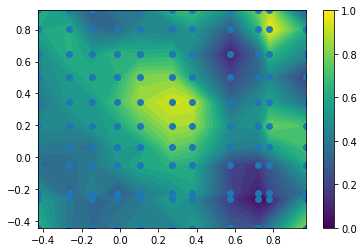

In [2]:
import matplotlib.pyplot as plt
from pyDOE2.doe_lhs import lhs

n = 11
np.random.seed(0)

def simulate(a, b):
    bi = np.pi * (2*a + 0.5*b + 1)
    return 0.1 * (np.sin(a*bi) + np.sin(b.T*bi))

x1 = np.sort(lhs(1, 11, random_state=0)*1.5 - 0.5, axis=0)
x2 = np.sort(lhs(1, 11, random_state=1)*1.5 - 0.5, axis=0)
X1, X2 = np.meshgrid(x1, x2)
X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])
y = simulate(X[:,0], X[:,1]).reshape(-1,1) + np.random.normal(0, 0.025, (121,1))

plt.contourf(X1, X2, y.reshape(n,n), levels=30);
plt.scatter(X[:,0], X[:,1]);
plt.colorbar();

X = torch.tensor(X)
y = torch.tensor(y)

In [3]:
X = (X - X.mean(dim=0))/X.std(dim=0)
y = (y - y.mean())/y.std()

In [4]:
torch.manual_seed(0)
model = NSGPRegression(X, y, 5, 0)
print(model.params)
# %debug
model.optimize_auto(1000, lr=0.001, gran=100, m=0, optim='adam')
with torch.no_grad():
    mean, var = model.predict(X)
    mean = mean.view(-1)
    std2 = torch.sqrt(var.diag())*2
    ls = model.get_LS(X)

{'local_gp_std': tensor([1.9701, 1.7078], requires_grad=True), 'local_gp_ls': tensor([1.4594, 1.9207], requires_grad=True), 'local_gp_noise': tensor([1.6450, 1.7911], requires_grad=True), 'latent_ls': tensor([[1.1786, 1.3511],
        [1.5813, 1.2882],
        [1.4529, 1.1768],
        [1.3553, 1.6219],
        [1.4818, 1.4408]], requires_grad=True), 'global_gp_std': tensor([1.4073], requires_grad=True), 'global_gp_noise': tensor([1.2054], requires_grad=True)}
49.32104682184301
46.19933987899682
42.66318861705746
37.22050210627301
29.334489905453665
23.581386080677973
19.7543084361459
17.89229220572509
16.59163119201492
15.212031957784774


In [45]:
np.random.seed(0)
n = 31
x1_test = np.sort(lhs(1, n, random_state=3)*1.5 - 0.5, axis=0)
x2_test = np.sort(lhs(1, n, random_state=4)*1.5 - 0.5, axis=0)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)

X_test = torch.tensor(np.array([(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]))
y_test = torch.tensor(np.array([simulate(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]).reshape(-1,1))
# print(X_test.shape, y_test.shape)

X_test = (X_test - X_test.mean(dim=0))/X_test.std(dim=0)
y_test = (y_test - y_test.mean())/y_test.std()

with torch.no_grad():
    mean, var = model.predict(X_test)
    ls = model.get_LS(X_test)
    print(torch.mean(torch.square(y_test-mean))/torch.var(y_test))

tensor(0.3197)


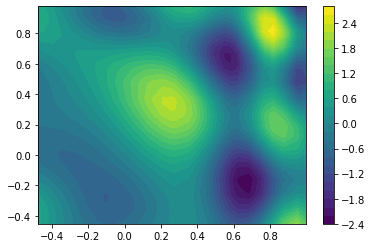

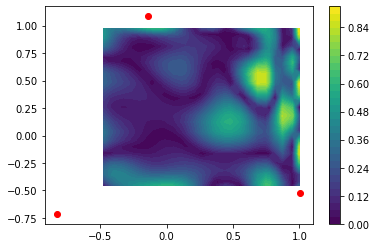

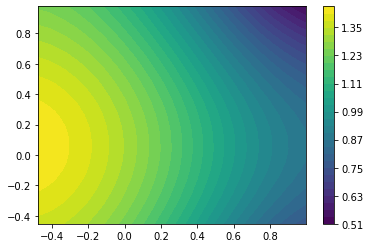

In [30]:
plt.contourf(X1_test, X2_test, mean.reshape(n,n), levels=30);
plt.colorbar();

plt.figure()
plt.scatter(model.X_bar[:,0], model.X_bar[:,1], c='r',zorder=10)
plt.contourf(X1_test, X2_test, torch.abs(mean.reshape(n,n)-y_test.reshape(n,n)), levels=30);
plt.colorbar();

plt.figure()
plt.contourf(X1_test, X2_test, torch.norm(torch.cat(ls, dim=1), dim=1).reshape(n,n), levels=30);
plt.colorbar();

In [23]:
model.params

{'local_gp_std': tensor([1.4647, 1.2875], requires_grad=True),
 'local_gp_ls': tensor([1.7819, 2.2415], requires_grad=True),
 'local_gp_noise': tensor([8.2350e-21, 2.7721e-02], requires_grad=True),
 'latent_ls': tensor([[0.4995, 0.8586],
         [1.0882, 0.8481],
         [0.9195, 0.6566]], requires_grad=True),
 'global_gp_std': tensor([1.8783], requires_grad=True),
 'global_gp_noise': tensor([0.4256], requires_grad=True)}


Name : GP regression
Objective : 109.39342828042024
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    1.419023690524704  |      +ve      |        
  rbf.lengthscale          |                 (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.07791992877204568  |      +ve      |        


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/likelihoods/gaussian.py:119: RuntimeWarning:invalid value encountered in sqrt
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


(GP_regression.rbf.lengthscale:
 Param([0.35935356, 0.56389858]),
 array([0.27914141]))

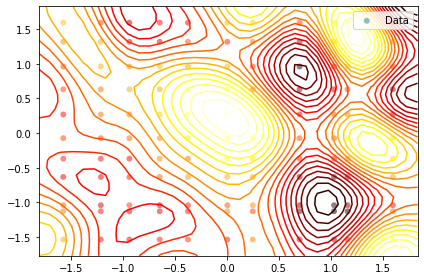

In [24]:
# n = 11
# np.random.seed(0)
# x1 = np.sort(np.linspace(-0.5, 1, n))
# # x2 = np.sort(np.random.uniform(-0.5, 1, n))
# X1, X2 = np.meshgrid(x1, x1)

# def simulate(a, b):
#     bi = np.pi * (2*a + 0.5*b + 1)
#     return 0.1 * (np.sin(a*bi) + np.sin(b*bi))

# y = np.array([simulate(a,b) for a,b in zip(X1.ravel(), X2.ravel())]).reshape(-1,1) + np.random.normal(0,0.025, n*n).reshape(-1,1)
# X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])

# plt.contourf(X1, X2, y.reshape(n, n), levels=30);
# plt.colorbar();

# print(X.shape, y.shape)
np.random.seed(0)
import GPy
m = GPy.models.GPRegression(X.numpy(), y.numpy(), GPy.kern.RBF(2, ARD=True))
m.optimize_restarts(20, verbose=False);
m.plot()
print(m)
m.kern.lengthscale, m['Gaussian_noise.variance']**.5

0.09224002733044982

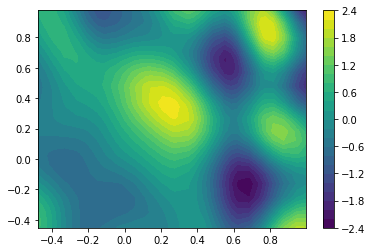

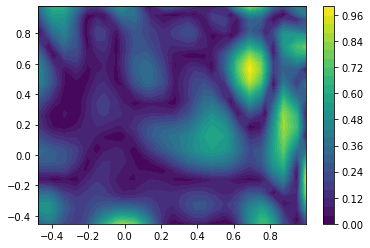

In [25]:
pred_y = m.predict(X_test.numpy())[0]

plt.contourf(X1_test, X2_test, pred_y.reshape(n,n), levels=30)
plt.colorbar()

plt.figure()
plt.contourf(X1_test, X2_test, np.abs(pred_y.reshape(n,n)-y_test.numpy().reshape(n,n)), levels=30)
plt.colorbar();
np.mean(np.square(y_test.numpy().ravel()-pred_y.ravel()))/np.var(y_test.numpy())